# Stock Similarity and Comparison through Dimensionality Reduction and Visualisation
by Chee-Foong（曾志峰）from Singapore（新加坡）on 31 Jul 2020


## Summary
This analysis aims to identify companies with factors that are different from their peers in the same industry.  However, one has to deal with many factors and very often not all of them are representative or are useful in clustering companies of similar qualities and attributes.

We use t-SNE (t-distributed stochastic neighbour embedding) algorithm here to reduce these complexity,  visualise how companies in different industries are clustered and identify companies that are fundamentally different from others.

## Import Libraries

In [1]:
import time
import re
import random
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
def getSymbolName(symbol):
    info = security_ref.loc[symbol]
    return info.display_name, info.stock_name

### Loading data

#### Security Information

In [3]:
security_ref = pd.read_csv('../data/security_ref.csv')
security_ref.set_index('symbol', inplace=True)

#### Prices

In [4]:
prices = pd.read_csv('../data/security_prices.csv')
prices.date = pd.to_datetime(prices.date)
prices.set_index('date', inplace=True)

#### Industry

In [5]:
security_industry = pd.read_csv('../data/security_industry.csv')
security_industry.set_index(['code'], inplace=True)

#### Factor List

In [6]:
factor_list = pd.read_csv('../data/factor_list.csv')
factor_list.category.value_counts()

quality      71
basics       37
emotion      36
momentum     34
style        30
pershare     15
technical    15
risk         12
growth        9
Name: category, dtype: int64

#### Factors

In [7]:
factor_data = pd.read_csv('../data/factor_data.csv')
factor_data.date = pd.to_datetime(factor_data.date)
factor_data.set_index(['date','factor'], inplace=True)

idx = pd.IndexSlice

Select interested factor types

In [8]:
FACTOR_TYPE_LIST = ['quality', 'basics'] ## 

factor_list = factor_list[factor_list.category.isin(FACTOR_TYPE_LIST)].factor
print('Number of interested factors: {}'.format(len(factor_list)))

Number of interested factors: 108


In [9]:
factor_list = factor_list.tolist()
# factor_list

Extract monthly factor data of all the securities

In [10]:
### TO BE CONFIRM

Focusing only 2020 data

In [11]:
factor_data_reduced = factor_data.loc[idx['2020',factor_list],:]

Calculate the mean factor value for each security over the query period  
Fill all NAs with factor median of all securities

In [12]:
avg_factor = factor_data_reduced.groupby('factor').agg('mean')

In [13]:
avg_factor = avg_factor.apply(lambda row: row.fillna(row.median()), axis=1)

In [14]:
avg_factor = avg_factor.T
avg_factor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 000001.XSHE to 603993.XSHG
Columns: 108 entries, ACCA to value_change_profit_ttm
dtypes: float64(108)
memory usage: 255.5+ KB


### Normalising factor data

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
avg_factor_scaled = pd.DataFrame(scaler.fit_transform(avg_factor))

avg_factor_scaled.columns = avg_factor.columns
avg_factor_scaled.index = avg_factor.index

### Remove factors with little variance

In [16]:
from sklearn.feature_selection import VarianceThreshold

print(avg_factor_scaled.shape)

sel = VarianceThreshold(threshold=1)
sel.fit(avg_factor_scaled)

mask = sel.get_support()

avg_factor_reduced = avg_factor_scaled.loc[:,mask]

print(avg_factor_reduced.shape)

(300, 108)
(300, 45)


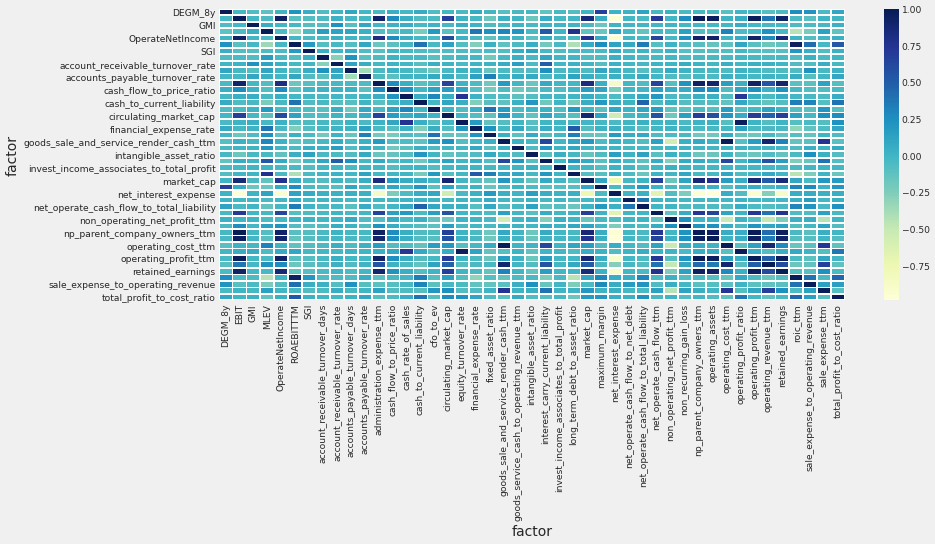

In [17]:
sns.heatmap(avg_factor_reduced.corr(), cmap="YlGnBu", center=0, linewidths=1, annot=False, fmt=".2f")
plt.show()

### Removing highly correlated features

In [18]:
corr_matrix = avg_factor_reduced.corr()

# Create positive correlation matrix
corr_df = avg_factor_reduced.corr().abs()

# Create and apply mask
mask = np.triu(np.ones_like(corr_df, dtype=bool)) 
tri_df = corr_matrix.mask(mask)

# Find columns that meet treshold
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]

print(to_drop)

avg_factor_reduced = avg_factor_reduced.drop(to_drop, axis=1)

['EBIT', 'ROAEBITTTM', 'equity_turnover_rate', 'goods_sale_and_service_render_cash_ttm', 'np_parent_company_owners_ttm', 'operating_assets', 'operating_profit_ttm']


## t-SNE visualisation of high-dimensional data

In [19]:
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50)

tsne_features = m.fit_transform(avg_factor_reduced)

In [20]:
avg_factor_reduced['tsne_X'] = tsne_features[:,0]
avg_factor_reduced['tsne_Y'] = tsne_features[:,1]

### Consolidating all data for visualisation

In [21]:
industry_map = {'金融指数': 'Financials',
 '房地产指数': 'Real Estate',
 '信息技术指数': 'Technology',
 '可选消费指数': 'Consumer Discretionary',
 '工业指数': 'Industrials',
 '医疗保健指数': 'Healthcare',
 '日常消费指数': 'Consumer Staples',
 '材料指数': 'Materials',
 '能源指数': 'Energy',
 '公用事业指数': 'Utilities',
 '电信服务指数': 'Telecom'}

In [22]:
avg_factor_tSNE = security_ref.join(security_industry)
avg_factor_tSNE['sector'] = avg_factor_tSNE.industry_name.map(industry_map)
avg_factor_tSNE = avg_factor_tSNE.join(avg_factor_reduced[['tsne_X','tsne_Y']]).dropna()

In [23]:
avg_factor_tSNE.head()

,display_name,stock_name,industry_code,industry_name,sector,tsne_X,tsne_Y
symbol,,,,,,,
000001.XSHE,平安银行,PAYX,HY007,金融指数,Financials,-16.811644,-0.175958
000002.XSHE,万科A,WKA,HY011,房地产指数,Real Estate,-19.169939,6.584532
000063.XSHE,中兴通讯,ZXTX,HY008,信息技术指数,Technology,0.319493,-8.366244
000066.XSHE,中国长城,ZGCC,HY008,信息技术指数,Technology,-5.742792,-4.737537
000069.XSHE,华侨城A,HQCA,HY004,可选消费指数,Consumer Discretionary,-1.892932,-11.671571


### Scatter Plot Visualisation

In [24]:
def scatter_text(x, y, hue, data, text_column='', subset='', title='', xlabel='', ylabel=''):

    fig_dims = (15, 10)
    fig, ax = plt.subplots(figsize=fig_dims)

    sns.scatterplot(x="tsne_X", y="tsne_Y", hue=hue, s=200, data=data, ax=ax) 

    if subset: 
        data = data[data[hue] == subset]
        if not title: title = subset

    if text_column:
        # Add text besides each point
        for line in range(0,data.shape[0]):
             ax.text(data[x][line]+0.01, data[y][line], 
                     data[text_column][line], horizontalalignment='left', 
                     size='medium', color='black', weight='semibold')

    # Set title and axis labels
    if title: plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)

    plt.show()


Observed and expected that companies in the same industry should be close to each other based on their basic and quality factors.

Companies that deviate are worth study why they are different from the rest.

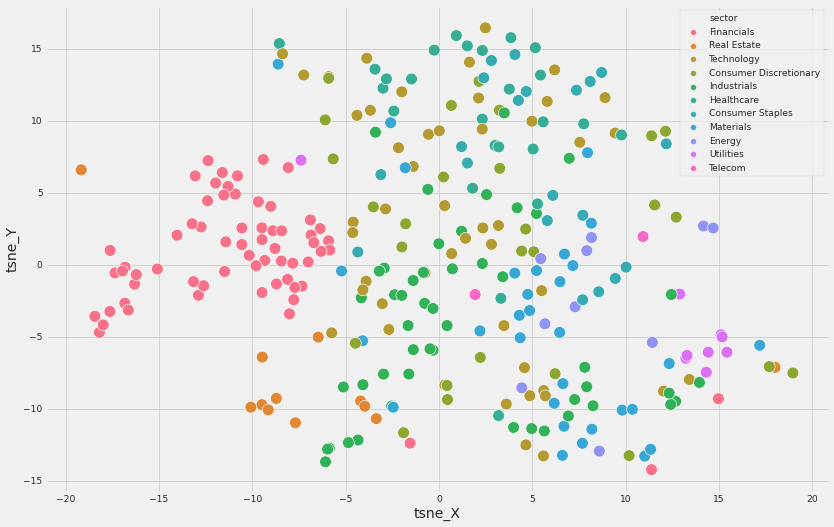

In [25]:
scatter_text(x="tsne_X", y="tsne_Y", 
             hue='sector', 
             data=avg_factor_tSNE)

## Analysis
### Financials

Filter by industry and label by company names

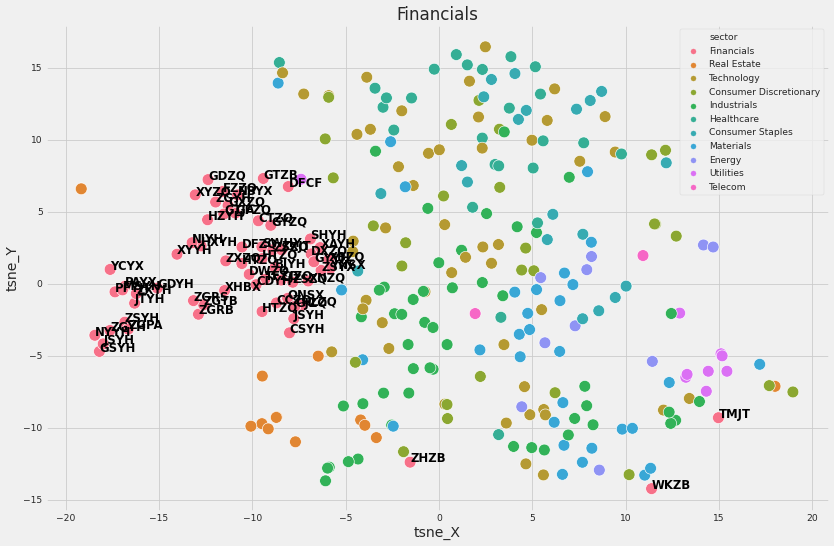

In [26]:
scatter_text(x="tsne_X", y="tsne_Y", 
             hue='sector', 
             data=avg_factor_tSNE,
             text_column='stock_name',
             subset='Financials')

In [27]:
avg_factor_tSNE[avg_factor_tSNE.stock_name.isin(['TMJT','ZHZB','WKZB'])]

,display_name,stock_name,industry_code,industry_name,sector,tsne_X,tsne_Y
symbol,,,,,,,
000627.XSHE,天茂集团,TMJT,HY007,金融指数,Financials,14.976020,-9.310257
600390.XSHG,五矿资本,WKZB,HY007,金融指数,Financials,11.395423,-14.237853
600705.XSHG,中航资本,ZHZB,HY007,金融指数,Financials,-1.542331,-12.397874


In [28]:
selected_stocks = avg_factor_tSNE[avg_factor_tSNE.stock_name.isin(['TMJT','YCYX','ZSYX'])].index
selected_stocks = selected_stocks.tolist()

sector_bmk = ['399914.XSHE'] ## 沪深300金融地产指数

prices_reduced = prices[selected_stocks + sector_bmk]

sampled_prices = prices_reduced.resample('D').fillna('ffill')
sampled_returns = sampled_prices.pct_change().dropna(axis=0, how='all')
sampled_returns = sampled_returns['2020']

Cumulative Returns vs Benchmark

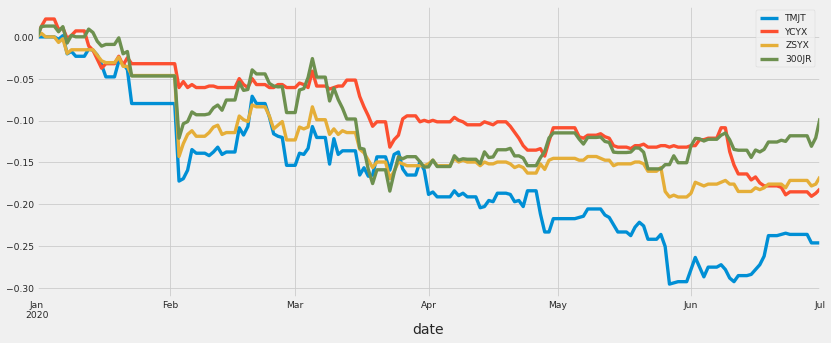

In [29]:
cumulative_returns = ((1 + sampled_returns).cumprod()-1) 
cumulative_returns.columns = [getSymbolName(col)[1] for col in cumulative_returns.columns]
cumulative_returns.plot()
plt.show()

Of the three selected stocks, all underperforms the benchmark.  From the scatter plot, financial companies are clustered in 2 groups.  Fundamentally, these 3 companies are quite different from the rest in the 2 clusters.  Worth a deeper dive into the company financials and operations.

### Utilities

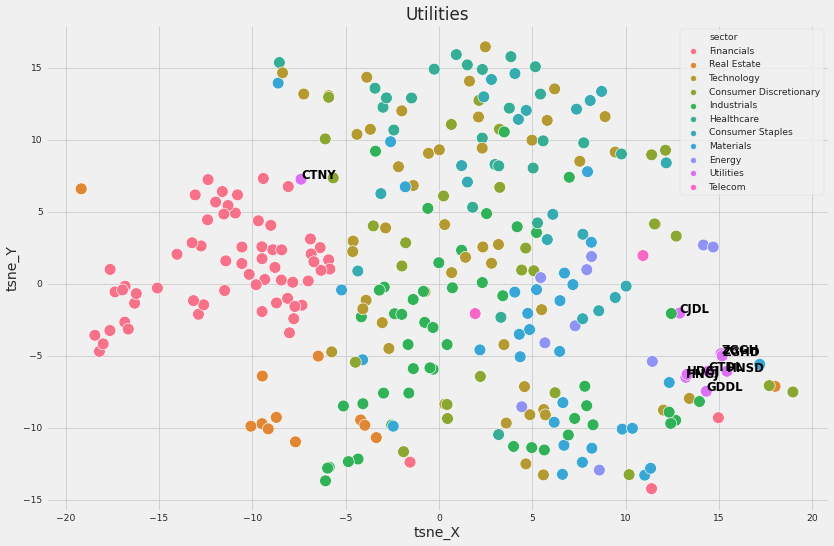

In [30]:
scatter_text(x="tsne_X", y="tsne_Y", 
             hue='sector', 
             data=avg_factor_tSNE,
             text_column='stock_name',
             subset='Utilities')

In [31]:
avg_factor_tSNE[avg_factor_tSNE.stock_name.isin(['CTNY','CJDL'])]

,display_name,stock_name,industry_code,industry_name,sector,tsne_X,tsne_Y
symbol,,,,,,,
600674.XSHG,川投能源,CTNY,HY010,公用事业指数,Utilities,-7.386427,7.254117
600900.XSHG,长江电力,CJDL,HY010,公用事业指数,Utilities,12.901839,-2.044098


In [32]:
selected_stocks = avg_factor_tSNE[avg_factor_tSNE.stock_name.isin(['CTNY','CJDL'])].index
selected_stocks = selected_stocks.tolist()

sector_bmk = ['399917.XSHE'] ## 沪深300公用事业指数

prices_reduced = prices[selected_stocks + sector_bmk]

sampled_prices = prices_reduced.resample('D').fillna('ffill')
sampled_returns = sampled_prices.pct_change().dropna(axis=0, how='all')
sampled_returns = sampled_returns['2020']

Cumulative Returns vs Benchmark

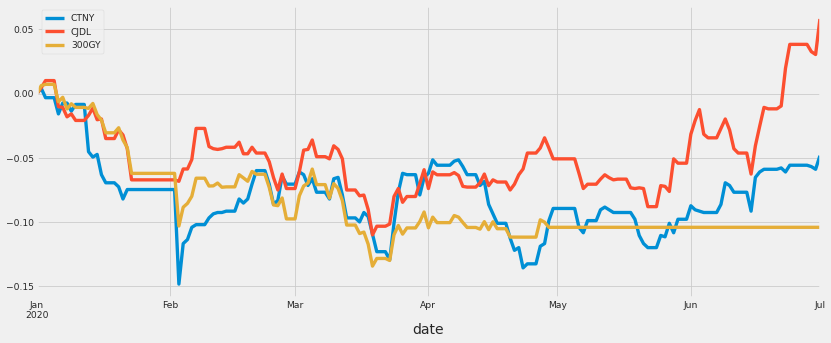

In [33]:
cumulative_returns = ((1 + sampled_returns).cumprod()-1) 
cumulative_returns.columns = [getSymbolName(col)[1] for col in cumulative_returns.columns]
cumulative_returns.plot()
plt.show()

Observed benchmark cumulative returns are flat recently.  This could be due to incomplete index data.  Nevertheless, CTNY and CJDL have outperformed the benchmark.  Its fundamentals and quality are likely to be good compared with the rest in the same industry.

### Real Estate

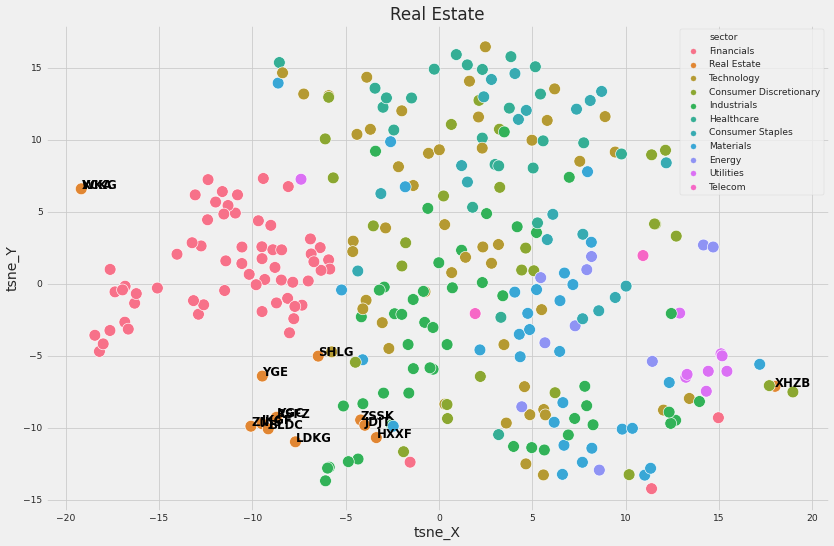

In [34]:
scatter_text(x="tsne_X", y="tsne_Y", 
             hue='sector', 
             data=avg_factor_tSNE,
             text_column='stock_name',
             subset='Real Estate')

In [38]:
avg_factor_tSNE[avg_factor_tSNE.stock_name.isin(['YGE','SHLG','XHZB'])]

,display_name,stock_name,industry_code,industry_name,sector,tsne_X,tsne_Y
symbol,,,,,,,
600177.XSHG,雅戈尔,YGE,HY011,房地产指数,Real Estate,-9.459708,-6.417285
600208.XSHG,新湖中宝,XHZB,HY011,房地产指数,Real Estate,18.010883,-7.130321
600848.XSHG,上海临港,SHLG,HY011,房地产指数,Real Estate,-6.464256,-5.032037


In [41]:
selected_stocks = avg_factor_tSNE[avg_factor_tSNE.stock_name.isin(['YGE','SHLG','XHZB'])].index
selected_stocks = selected_stocks.tolist()

sector_bmk = ['399952.XSHE'] ## 沪深300地产指数

prices_reduced = prices[selected_stocks + sector_bmk]

sampled_prices = prices_reduced.resample('D').fillna('ffill')
sampled_returns = sampled_prices.pct_change().dropna(axis=0, how='all')
sampled_returns = sampled_returns['2020']

Cumulative Returns vs Benchmark

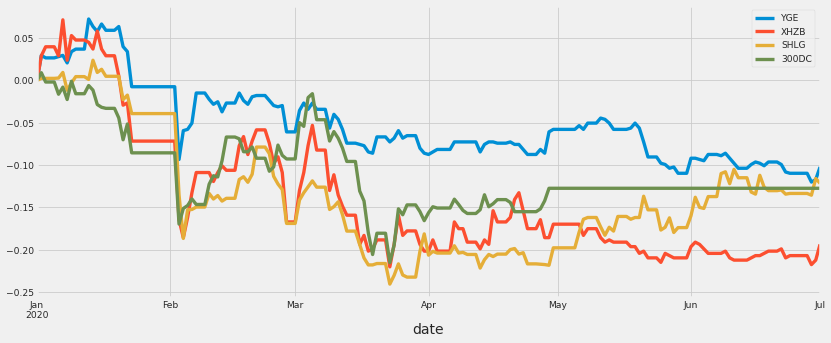

In [42]:
cumulative_returns = ((1 + sampled_returns).cumprod()-1) 
cumulative_returns.columns = [getSymbolName(col)[1] for col in cumulative_returns.columns]
cumulative_returns.plot()
plt.show()

Observed benchmark cumulative returns are flat recently.  This could be due to incomplete index data.  Not much difference in terms of price performance for the selected stock here.